# Import Libraries and Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from sklearn import linear_model
import torch
import torch.nn as nn
from tqdm import tqdm

from sklearn.metrics import roc_auc_score

In [2]:
DATA_PATH = '../data'
MODEL_PATH = '../src/models'

### Util Functions

In [3]:
def train_valid_test_split(X, y, TEST_SIZE=0.2, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(
        X, 
        y, 
        test_size = TEST_SIZE, 
        random_state=random_state
    )

    X_train, X_valid, y_train, y_valid = train_test_split(
        X_train, 
        y_train, 
        test_size = TEST_SIZE, 
        random_state=random_state
    )

    return X_train, X_valid, X_test, y_train, y_valid, y_test

In [4]:
def get_metrics(pred, actual, display=True):
    cm = confusion_matrix(actual, pred)
    tn, fp, fn, tp = cm.ravel()

    TPR = tp / (tp + fn)
    FPR = tn / (tn + fp)
    roc_auc = roc_auc_score(actual, pred)
    if (display):
        print(f"Accuracy: {np.mean(pred == actual):.4f}")
        print(f"tn:  {tn},  fp:  {fp},  fn:  {fn}, tp:  {tp}")
        print(f"Precision:\t\t\t{tp / (tp + fp):.5f}")
        print(f"Recall:\t\t\t\t{tp / (tp + fn):.5f}")
        print(f"TPR:\t\t\t\t{TPR:.5f}")
        print(f"FPR:\t\t\t\t{FPR:.5f}")
        print(f"Positive likelihood ratio:\t{TPR/FPR:.5f}")
        print(f"Negative likelihood ratio:\t{FPR/TPR:.5f}")
        print(f"ROC-AUC Score:\t{roc_auc:.5f}")
        return
    return [tn, fp, fn, tp, TPR, FPR, TPR/FPR, FPR/TPR, roc_auc]

## Final Feature Matrix

In [5]:
# Get Logistic Regression Data
feature_matrix = pd.read_csv(f'{DATA_PATH}/processed/log_reg_feature_matrix.csv')
feature_matrix.head()

,FPF_TARGET,ESSENTIAL_SERVICES_slp,medianLOAN,BNPL_mean,meanCHILD_DEPENDENTS,total_balance,GENERAL_MERCHANDISE_prop,minCREDIT_CARD_PAYMENT,GROCERIES_count,meanGROCERIES,...,RENT_count,TRAVEL_count,TAX_mean,UNCATEGORIZED_prop,ATM_CASH_slp,maxACCOUNT_FEES,maxEDUCATION,minAUTOMOTIVE,LOAN_mean,RENT_prop
0,0.0,-2.063860,301.58,0.0,0.0,857.150161,0.083363,3.63,10.730769,58.130215,...,0.0,1.375000,0.000000,0.089842,40.049989,23.0,45.13,2.00,345.082200,0.0
1,0.0,-37.036209,807.11,0.0,0.0,43016.714011,0.102295,10.48,20.076923,101.452452,...,0.0,2.615385,140.326667,0.246412,-83.024286,34.0,62.49,2.19,866.531397,0.0
2,0.0,7.498741,2154.48,0.0,0.0,14667.666944,0.068612,2.39,7.769231,42.681584,...,0.0,1.000000,0.000000,0.001825,69.475385,34.0,0.00,1.71,1802.527857,0.0
3,0.0,-22.930495,1400.00,0.0,0.0,-4188.933058,0.155554,10.00,3.833333,88.043261,...,0.0,2.000000,0.000000,0.016086,31.785714,149.0,180.00,4.13,933.743056,0.0
4,0.0,14.604286,2109.36,0.0,0.0,-2630.480387,0.045677,100.00,3.800000,112.683158,...,0.0,2.888889,0.000000,0.140562,-40.421727,14.0,56.45,1.91,2457.143333,0.0


In [6]:
# Train Test Split
TEST_SIZE = 0.2
X = feature_matrix.iloc[:,1:].to_numpy()
y = feature_matrix.iloc[:,0].to_numpy()

X_train, X_valid, X_test, y_train, y_valid, y_test = train_valid_test_split(
    X, 
    y, 
    TEST_SIZE = TEST_SIZE, 
    random_state = 42
)

# Prototype Model to Predict Default Risk

### Training

In [23]:
lin_model = linear_model.LogisticRegression(max_iter=10000)

In [24]:
lin_model.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

### Evaluate Model

In [25]:
valid_pred = lin_model.predict(X_valid)
test_pred = lin_model.predict(X_test)

In [26]:
print("Validation:")
get_metrics(valid_pred, y_valid)
print("===========================")
print("Test:")
get_metrics(test_pred, y_test)

Validation:
Accuracy: 0.7904
tn:  371,  fp:  4,  fn:  96, tp:  6
Precision:			0.60000
Recall:				0.05882
TPR:				0.05882
FPR:				0.98933
Positive likelihood ratio:	0.05946
Negative likelihood ratio:	16.81867
ROC-AUC Score:	0.52408
Test:
Accuracy: 0.8339
tn:  492,  fp:  6,  fn:  93, tp:  5
Precision:			0.45455
Recall:				0.05102
TPR:				0.05102
FPR:				0.98795
Positive likelihood ratio:	0.05164
Negative likelihood ratio:	19.36386
ROC-AUC Score:	0.51949


# Prototype 2: Basic Sequential NN

### Get Data

In [11]:
# Get SNN Data
feature_matrix = pd.read_csv(f'{DATA_PATH}/processed/SNN_feature_matrix.csv')
feature_matrix.head()

,FPF_TARGET,minEDUCATION,maxFOOD_AND_BEVERAGES,BILLS_UTILITIES_prop,UNCATEGORIZED_prop,minHOME_IMPROVEMENT,RENT_mean,INSURANCE_mean,meanLOAN,meanCREDIT_CARD_PAYMENT,...,minPAYCHECK,AUTOMOTIVE_slp,maxCREDIT_CARD_PAYMENT,medianUNCATEGORIZED,PETS_slp,LOAN_slp,minMORTGAGE,meanEXTERNAL_TRANSFER,meanBILLS_UTILITIES,stdbalance
0,0.0,33.26,326.45,0.0,0.089842,1.98,0.0,89.423571,358.890312,311.720326,...,0.0,-11.050222,2371.71,37.000,-63.700000,-18.541469,1345.91,79.478235,0.0,125.590741
1,0.0,10.00,505.95,0.0,0.246412,102.43,0.0,401.003718,928.079878,988.767167,...,0.0,-51.708601,5729.39,200.000,0.000000,573.156813,0.00,826.376709,0.0,13215.093678
2,0.0,0.00,112.99,0.0,0.001825,16.39,0.0,90.264091,1713.210000,151.407725,...,0.0,-8.617238,2500.00,19.765,0.000000,268.779643,0.00,464.490968,0.0,17278.364208
3,0.0,20.00,514.23,0.0,0.016086,27.76,0.0,180.296410,874.035714,224.630698,...,0.0,21.904371,1500.00,21.720,2.510105,-34.430944,0.00,108.286707,0.0,4514.989935
4,0.0,56.45,500.00,0.0,0.140562,231.37,0.0,896.420000,2318.397000,172.375000,...,0.0,18.470070,391.00,20.000,0.974000,183.787500,0.00,192.407646,0.0,438.528721


In [12]:
# Train Test Split
TEST_SIZE = 0.2
X = feature_matrix.iloc[:,1:].to_numpy()
y = feature_matrix.iloc[:,0].to_numpy()

X_train, X_valid, X_test, y_train, y_valid, y_test = train_valid_test_split(
    X, 
    y, 
    TEST_SIZE = TEST_SIZE, 
    random_state = 42
)

### Define Model

In [13]:
# Define the model
model = nn.Sequential(
    nn.Linear(X.shape[1], 12),
    nn.ReLU(),
    nn.Linear(12, 24),
    nn.ReLU(),
    nn.Linear(24, 24),
    nn.ReLU(),
    nn.Linear(24, 12),
    nn.ReLU(),
    nn.Linear(12, 6),
    nn.ReLU(),
    nn.Linear(6, 1),
    nn.Sigmoid()
)

In [14]:
# loss function and optimizer
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

### Training

In [15]:
# training parameters
n_epochs = 200   # number of epochs to run
batch_size = 16  # size of each batch

In [16]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_valid_tensor = torch.tensor(X_valid, dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid, dtype=torch.float32).reshape(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

In [17]:
def train_SNN(
        model, 
        loss_fn, 
        optimizer, 
        X_train_tensor, 
        y_train_tensor, 
        X_valid_tensor, 
        y_valid_tensor, 
        n_epochs=n_epochs,
        batch_size=batch_size, 
        display=True):
    
    batch_start = torch.arange(0, X_train_tensor.shape[0], batch_size)
    train_history = []
    valid_history = []
    best_valid = np.inf
    
    # training loop
    bar = tqdm(range(n_epochs))
    for epoch in bar:
        model.train()
        bar.set_description(f"Epoch {epoch+1}")
        for start in batch_start:
            # take a batch
            X_batch = X_train_tensor[start:start+batch_size]
            y_batch = y_train_tensor[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred_train = model(X_train_tensor)
        y_pred_valid = model(X_valid_tensor)
        train_loss = float(loss_fn(y_pred_train, y_train_tensor))
        valid_loss = float(loss_fn(y_pred_valid, y_valid_tensor))
        
        bar.set_postfix(Train_MSE = float(train_loss), Valid_MSE = float(valid_loss))
        train_history.append(train_loss)
        valid_history.append(valid_loss)

        if (valid_loss < best_valid):
            torch.save(model.state_dict(), f'{MODEL_PATH}/nn_base_params.pt')

    if display:
        print(f"Best Epoch: {np.argmin(valid_history)}")
        print(f"Loss: {np.min(valid_history)}")
    model.load_state_dict(torch.load(f'{MODEL_PATH}/nn_base_params.pt'))
    return model, train_history, valid_history

In [18]:
model, train_history, valid_history = train_SNN(
    model, 
    loss_fn,
    optimizer,
    X_train_tensor, 
    y_train_tensor, 
    X_valid_tensor, 
    y_valid_tensor, 
    n_epochs = 200,
    batch_size = 64,
    display=False
)

Epoch 1:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 200: 100%|██████████| 200/200 [00:16<00:00, 11.84it/s, Train_MSE=0.296, Valid_MSE=0.501]


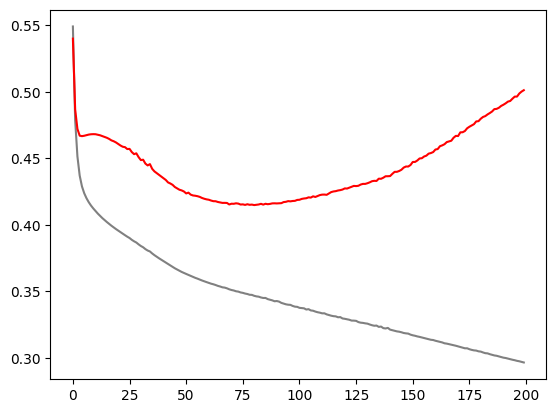

In [19]:
plt.plot(train_history, 'gray')
plt.plot(valid_history, 'r')

### Evaluate Model

In [20]:
# train_pred = model.predict(X_train)
def standardize_output(arr):
    return (1 / (1 + np.e ** (-1 * arr)))

def find_best_prob(pred_prob, actual, display=True):
    best_prob = 0
    best_score = -np.inf
    prob_interval = 0.05
    with np.errstate(divide='ignore'):
        if display:
            print(
                f"i\t" + 
                f"roc_auc\t" + 
                f"acc\t" + 
                f"conf_matrix" + 
                "\n==================================================="
            )
        for i in np.arange(0, 1.0, prob_interval):
            pred = pred_prob > i
            metrics = get_metrics(pred, actual, display=False)
            
            score = metrics[8]

            if display:
                print(
                    f"{i:.2f}\t" + 
                    f"{score:0.3f}\t" + 
                    f"{((metrics[0] + metrics[3]) / np.sum(metrics[:4]) * 100):.2f}\t" + 
                    f"{metrics[:4]}"
                )

            if (score > best_score):
                best_score = score
                best_prob = i
    if display: print(f"Best Threshold: {best_prob:0.2f}")
    return best_prob

In [21]:
valid_pred_prob = model(X_valid_tensor).detach().numpy()[:,0]
# valid_pred_prob = standardize_output(valid_pred_prob)
threshold = find_best_prob(valid_pred_prob, y_valid)
valid_pred = valid_pred_prob > threshold

test_pred_prob = model(X_test_tensor).detach().numpy()[:,0]
# test_pred_prob = standardize_output(test_pred_prob)
test_pred = test_pred_prob > threshold

i	roc_auc	acc	conf_matrix
0.00	0.533	26.62	[25, 350, 0, 102]
0.05	0.718	64.15	[219, 156, 15, 87]
0.10	0.728	67.92	[241, 134, 19, 83]
0.15	0.721	69.60	[254, 121, 24, 78]
0.20	0.720	71.70	[268, 107, 28, 74]
0.25	0.704	72.54	[278, 97, 34, 68]
0.30	0.688	73.38	[288, 87, 40, 62]
0.35	0.670	74.42	[300, 75, 47, 55]
0.40	0.666	77.78	[323, 52, 54, 48]
0.45	0.630	78.83	[340, 35, 66, 36]
0.50	0.569	78.20	[353, 22, 82, 20]
0.55	0.549	78.41	[360, 15, 88, 14]
0.60	0.539	78.62	[364, 11, 91, 11]
0.65	0.525	78.62	[368, 7, 95, 7]
0.70	0.507	77.99	[369, 6, 99, 3]
0.75	0.503	77.99	[370, 5, 100, 2]
0.80	0.493	77.57	[370, 5, 102, 0]
0.85	0.496	77.99	[372, 3, 102, 0]
0.90	0.500	78.62	[375, 0, 102, 0]
0.95	0.500	78.62	[375, 0, 102, 0]
Best Threshold: 0.10


In [22]:
print("Validation:")
get_metrics(valid_pred, y_valid)
print("===========================")
print("Testing:")
get_metrics(test_pred, y_test)

Validation:
Accuracy: 0.6792
tn:  241,  fp:  134,  fn:  19, tp:  83
Precision:			0.38249
Recall:				0.81373
TPR:				0.81373
FPR:				0.64267
Positive likelihood ratio:	1.26617
Negative likelihood ratio:	0.78978
ROC-AUC Score:	0.72820
Testing:
Accuracy: 0.6594
tn:  309,  fp:  189,  fn:  14, tp:  84
Precision:			0.30769
Recall:				0.85714
TPR:				0.85714
FPR:				0.62048
Positive likelihood ratio:	1.38141
Negative likelihood ratio:	0.72390
ROC-AUC Score:	0.73881
